In [11]:
from cobra.io import load_model, load_json_model
import time
import torch

In [12]:
# Contains the main steps of the BayesOpt
%run BayesOpt_MOBO.ipynb

In [13]:
# Plotting functions to be used across notebooks
%run Plotting_MOBO.ipynb

# Models & Media

## Load & Define

### Models

In [4]:
# load iML1515
model_iML1515 = load_model("iML1515")
medium_iML1515 = model_iML1515.medium
print(model_iML1515)

# load modified iJO1366
model_iJO1366_antiEpEX_scFv = load_json_model("iJO1366_producing_antiEpEX-scFv.json")
medium_iJO1366 = model_iJO1366_antiEpEX_scFv.medium
print(model_iJO1366_antiEpEX_scFv)

# load iBsu1103 producing surfactin (objective function: biomass + surfactin production, 95:5 ratio)
model_iBsu1103 = load_json_model("iBsu1103_producing_surfactin_combined_objective.json")
medium_M9_iBsu1103 = model_iBsu1103.medium
print(model_iBsu1103)

iML1515
iJO1366_producing_antiEpEX-scFv
iBsu1121VCorrected


### Media
* costs are in £/mol
* The optimum concentrations of glutamine, arginine and asparagine suggested by the models to achieve maximum antiEpEX-scFv levels with high solubility were 9.9, 9.5 and 6.1 mM respectively. Using the same arguments as for the conversion of Molar to flux bounds,
they sit at 4.95, 4.75, 3.05. -> set as default and change bounds accordingly

In [5]:
# M9 with essential trace metals
medium_iJO1366_reduced = {
    'EX_pi_e': 34.90, # in M9
    'EX_mn2_e': 0.001, # - required?; drops at 0.0001
    'EX_fe2_e': 0.1, # - required?; drops at 0.01
    'EX_glc__D_e': 10.0, # in M9
    'EX_zn2_e': 0.001, # - required?; drops at 0.0001
    'EX_mg2_e': 1.0, # in M9 
    'EX_ca2_e': 0.05, # in M9
    'EX_ni2_e': 0.001, # - required?; drops at 0.0001
    'EX_cu2_e': 0.001, # - required?; drops at 0.0001
    'EX_cobalt2_e': 0.0001, # - required; drops at 0.00001 
    'EX_mobd_e': 0.0005, # - required?; drops at 0.000001
    'EX_so4_e': 1.0, # in M9
    'EX_nh4_e': 9.3475, # in M9
    'EX_k_e': 11.02, # in M9
    'EX_na1_e': 52.038, # in M9
    'EX_cl_e': 13.6755, # in M9
    'EX_o2_e': 20.0, # in M9 II - drops at 10
}
bounds_iJO1366_reduced = { # 9 decision variables
    'EX_pi_e': (0.0, 50),
    'EX_mn2_e': (0.001, 0.001), # fix "trace" 
    'EX_fe2_e': (0.1, 0.1), # fix "trace"
    'EX_glc__D_e': (1.0, 10),
    'EX_zn2_e': (0.001, 0.001), # fix "trace"
    'EX_mg2_e': (0.0, 10),
    'EX_ca2_e': (0.0, 10),
    'EX_ni2_e': (0.001, 0.001), # fix "trace"
    'EX_cu2_e': (0.001, 0.001), # fix "trace"
    'EX_cobalt2_e': (0.0001, 0.0001), # fix "trace"
    'EX_mobd_e': (0.0005, 0.0005), # fix "trace"
    'EX_so4_e': (0.0, 10),
    'EX_nh4_e': (0.0, 10),
    'EX_k_e': (0.0, 20),
    'EX_na1_e': (0.0, 100.0), # fix - can be set to 0
    'EX_cl_e': (0.0, 20),
    'EX_o2_e': (0, 20), # upper bound can't be set to 10 or lower
}
# costs are in £/mol
costs_iJO1366_reduced = {
    'EX_pi_e': 23.4234, # Phosphate - approximate (several sources)
    'EX_mn2_e': 0.0, #33.25, # Manganese - MnCl2·4H20
    'EX_fe2_e': 0.0, #37.5, # IronII - as iron sulfate FeSO4·7H2O
    'EX_glc__D_e': 7.7647236, # Glucose
    'EX_zn2_e': 0.0, #28.3, # Zinc - as Zn(CH3CHOOH)·H2O
    'EX_mg2_e': 19.1022, # Magnesium - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_ca2_e': 18.08223, # Calcium - as CaCl2·2H2O
    'EX_ni2_e': 0.0, #53.24, # Nickel - as NiCl2·6H2O
    'EX_cu2_e': 0.0, #31.37, # Copper - CuCl2·2H2O
    'EX_cobalt2_e': 0.0, #114.39, # Cobalt - as CoCl2·6H2O
    'EX_mobd_e': 0.0, #184.12, # Molybdenum - molybdate NaMoO4·2H2O
    'EX_so4_e': 19.1022, # Sulfate - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_nh4_e': 3.6748, # Ammonia - as NH4Cl - approximate (several sources and "side-effect"
    'EX_k_e': 20.82177, # Potassium - as KCl - approximate (several sources and "side-effect"
    'EX_na1_e': 0.0, # Sodium - as NaCl, Na2HPO4
    'EX_cl_e': 3.03888, # Chlorid - as NaCl, NH4Cl, CaCl2 - approximate price from NaCl
    'EX_o2_e': 0.0, # oxygen - no costs
}

# M9 with essential trace metals and amino acids
medium_iJO1366_enriched = {
    'EX_pi_e': 34.90, # in M9
    'EX_mn2_e': 0.001, # - required?; drops at 0.0001
    'EX_fe2_e': 0.1, # - required?; drops at 0.01
    'EX_glc__D_e': 10.0, # in M9
    'EX_zn2_e': 0.001, # - required?; drops at 0.0001
    'EX_mg2_e': 1.0, # in M9 
    'EX_ca2_e': 0.05, # in M9
    'EX_ni2_e': 0.001, # - required?; drops at 0.0001
    'EX_cu2_e': 0.001, # - required?; drops at 0.0001
    'EX_cobalt2_e': 0.0001, # - required; drops at 0.00001 
    'EX_mobd_e': 0.0005, # - required?; drops at 0.0001 - higher than for iML1515
    'EX_so4_e': 1.0, # in M9
    'EX_nh4_e': 9.3475, # in M9 # lower than with 10
    'EX_k_e': 11.02, # in M9
    'EX_na1_e': 52.038, # in M9
    'EX_cl_e': 13.6755, # in M9
    'EX_o2_e': 20.0, # in M9 II - drops at 10
    'EX_arg__L_e': 4.75, # L-Arginine
    'EX_asn__L_e': 3.05, # L-Asparagine
    'EX_gln__L_e' : 4.95 # L-Glutamine
}
bounds_iJO1366_enriched = { # 12 decision variables
    'EX_pi_e': (0.0, 50),
    'EX_mn2_e': (0.001, 0.001), # fixed "trace" 
    'EX_fe2_e': (0.1, 0.1), # fixed "trace"
    'EX_glc__D_e': (1.0, 10),
    'EX_zn2_e': (0.001, 0.001), # fixed "trace"
    'EX_mg2_e': (0.0, 10),
    'EX_ca2_e': (0.0, 10),
    'EX_ni2_e': (0.001, 0.001), # fixed "trace"
    'EX_cu2_e': (0.001, 0.001), # fixed "trace"
    'EX_cobalt2_e': (0.0001, 0.0001), # fixed "trace"
    'EX_mobd_e': (0.0005, 0.0005), # fixed "trace"
    'EX_so4_e': (0.0, 10),
    'EX_nh4_e': (0.0, 10), # close to the default of 9.3475
    'EX_k_e': (0.0, 20),
    'EX_na1_e': (0.0, 100.0), # if fixed - can be set to 0
    'EX_cl_e': (0.0, 20),
    'EX_o2_e': (0, 20), # if fixed - can't be set to 10 or lower
    'EX_arg__L_e': (0.0, 10.0), # L-Arginine
    'EX_asn__L_e': (0.0, 10.0), # L-Asparagine
    'EX_gln__L_e' : (0.0, 10.0) # L-Glutamine
}
# costs are in £/mol
costs_iJO1366_enriched = {
    'EX_pi_e': 23.4234, # Phosphate - approximate (several sources)
    'EX_mn2_e': 0.0, #33.25, # Manganese - MnCl2·4H20
    'EX_fe2_e': 0.0, #37.5, # IronII - as iron sulfate FeSO4·7H2O
    'EX_glc__D_e': 7.7647236, # Glucose
    'EX_zn2_e': 0.0, #28.3, # Zinc - as Zn(CH3CHOOH)·H2O
    'EX_mg2_e': 19.1022, # Magnesium - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_ca2_e': 18.08223, # Calcium - as CaCl2·2H2O
    'EX_ni2_e': 0.0, #53.24, # Nickel - as NiCl2·6H2O
    'EX_cu2_e': 0.0, #31.37, # Copper - CuCl2·2H2O
    'EX_cobalt2_e': 0.0, #114.39, # Cobalt - as CoCl2·6H2O
    'EX_mobd_e': 0.0, #184.12, # Molybdenum - molybdate NaMoO4·2H2O
    'EX_so4_e': 19.1022, # Sulfate - as MgSO4·7H2O - approximate bc. half of 38.2044
    'EX_nh4_e': 3.6748, # Ammonia - as NH4Cl - approximate (several sources and "side-effect"
    'EX_k_e': 20.82177, # Potassium - as KCl - approximate (several sources and "side-effect"
    'EX_na1_e': 0.0, # Sodium - as NaCl, Na2HPO4
    'EX_cl_e': 3.03888, # Chlorid - as NaCl, NH4Cl, CaCl2 - approximate price from NaCl
    'EX_o2_e': 0.0, # oxygen - no costs
    'EX_arg__L_e': 61.1442, # L-Arginine
    'EX_asn__L_e': 93.01248, # L-Asparagine
    'EX_gln__L_e' : 80.23086 # L-Glutamine
}

"""
Media, bounds and costs for iBsu1103 model (different IDs than iJO1366 and iML1515)
"""
medium_M9_iBsu1103 = {
    'EX_cpd00013_b': 9.3745, # Ammonia
    'EX_cpd00063_b': 0.05, # Calcium
    'EX_cpd00027_b': 10, # Carbon - Glucose
    'EX_cpd00254_b': 1, # Magnesium
    'EX_cpd10516_b': 0.1, # Iron Fe3+ (reactant in biomass reaction)
    'EX_cpd00009_b': 34.90, # Phosphate 
    'EX_cpd00205_b': 11.02, # Potassium
    'EX_cpd00048_b': 1, # Sulfate
    'EX_cpd00011_b': 0.0, # Carbon Dioxide 
    'EX_cpd00067_b': 0.0, # Hydrogen 
    'EX_cpd00001_b': 0.0, # Water 
    'EX_cpd00007_b': 20.0 # Oxygen 
}

bounds_M9_iBsu1103 = {
    'EX_cpd00013_b': (0.0, 10),
    'EX_cpd00063_b': (0.0, 10),
    'EX_cpd00027_b': (1.0, 10),
    'EX_cpd00254_b': (0.0, 10),
    'EX_cpd10516_b': (0.0, 10),
    'EX_cpd00009_b': (0.0, 50),
    'EX_cpd00205_b': (0.0, 20),
    'EX_cpd00048_b': (0.0, 10),
    'EX_cpd00011_b': (0.0, 10),  
    'EX_cpd00067_b': (0.0, 10),  
    'EX_cpd00001_b': (0.0, 10),  
    'EX_cpd00007_b': (0, 20) 
}

costs_M9_iBsu1103 = {
    'EX_cpd00013_b': 10.099587, 
    'EX_cpd00063_b': 18.08223, 
    'EX_cpd00027_b': 7.7647236, 
    'EX_cpd00254_b': 19.1022, 
    'EX_cpd10516_b': 0.1, 
    'EX_cpd00009_b': 23.4234, 
    'EX_cpd00205_b': 20.82177, 
    'EX_cpd00048_b': 19.1022, 
    'EX_cpd00011_b': 0.0, 
    'EX_cpd00067_b': 0.0, 
    'EX_cpd00001_b': 0.0, 
    'EX_cpd00007_b': 0.0, 
}

## Explore Model Behaviour Given Different Media Compositions

### Default Behaviour
* biomass as only objective
* unlimited growth rate

In [ ]:
print("Model objective:\n", model_iJO1366_antiEpEX_scFv.objective)
# assign enriched medium to model
model_iJO1366_antiEpEX_scFv.medium = medium_iJO1366_enriched
# run optimisation
solution = model_iJO1366_antiEpEX_scFv.optimize()
# print relevant fluxes of optimised flux distribution
print("Biomass flux:\t\t\t\t", solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"])
print("Recombinant protein prduction flux:\t", solution.fluxes["Recombinant_protein"])

### Behaviour Under Combined Objective

Change objective to a mix of growth and protein expression

Argument: The Ampicillin resistance is also expressed and required

* When "factor_bio" is set to 1, there is no production of the protein.
* When "factor_bio" is set to 0.99, M9 with aa and default with aa lead to a flux through the protein production while maintaining maximum growth.

In [ ]:
# extract biomass and production reaction ids
protein_rxn = model_iJO1366_antiEpEX_scFv.reactions.get_by_id("Recombinant_protein")
biomass_rxn = model_iJO1366_antiEpEX_scFv.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M")
biomass_rxn_bounds = biomass_rxn.bounds # default bounds of (0, 1000)
# limit growth rate to 0.85
biomass_rxn.bounds = (0.0, 0.85)


# create combined objective
factor_bio = 0.99 # when set to 1, only biomass production is optimised, when smaller, protein production included
factor_prot = 1 - factor_bio
combined_objective = model_iJO1366_antiEpEX_scFv.problem.Objective(
    factor_bio * model_iJO1366_antiEpEX_scFv.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux_expression + 
    factor_prot * model_iJO1366_antiEpEX_scFv.reactions.Recombinant_protein.flux_expression,
    direction = 'max')
# Set model objective to combined objective
model_iJO1366_antiEpEX_scFv.objective = combined_objective
print("Objective:\n", model_iJO1366_antiEpEX_scFv.objective)


# test performance of different growth media
model_iJO1366_antiEpEX_scFv.medium = medium_iJO1366_reduced
solution = model_iJO1366_antiEpEX_scFv.optimize()
print("\nM9 medium with trace metals:", 
      "\nBiomass flux:\t\t", solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"], 
      "\nProduction flux:\t", solution.fluxes["Recombinant_protein"])

model_iJO1366_antiEpEX_scFv.medium = medium_iJO1366_enriched
solution = model_iJO1366_antiEpEX_scFv.optimize()
print("\nM9 medium + optimal amino acid",
      "\nBiomass flux:\t\t", solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"],
      "\nProduction flux:\t", solution.fluxes["Recombinant_protein"])

model_iJO1366_antiEpEX_scFv.medium = medium_iJO1366
solution = model_iJO1366_antiEpEX_scFv.optimize()
print("\niJO1366 default medium",
      "\nBiomass flux:\t\t", solution.fluxes["BIOMASS_Ec_iJO1366_core_53p95M"],
      "\nProduction flux:\t", solution.fluxes["Recombinant_protein"])

# Running the Optimisation(s)

## iML1515

In [ ]:
# set n_iter and date to be used in all calls and names
date = "2025-11-27"
rounds = 1 # how often should the algorithm run
n_start = 50 # how many random media compositions to initialise the algorithm
n_iter = 100 # how many iterations per run
iterations = str(n_iter)
n_candidates = 15 # batch size

biomass_rxn_id = "BIOMASS_Ec_iML1515_core_75p37M"

# set medium
medium = medium_iJO1366_reduced
bounds = bounds_iJO1366_reduced
costs = costs_iJO1366_reduced
# setting the upper limit of oxygen to 20, reduces the maximum growth rate to 0.822
model_iML1515.medium = medium

"""performance with chosen medium"""
solution = model_iML1515.optimize()
# print relevant fluxes of optimised flux distribution
print("Biomass flux:\t", solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

# bounds of biomass reaction
biomass_rxn = model_iML1515.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M")
biomass_rxn.bounds = (0.0, 0.85)
# define objective as combination of growth (biomass) and production
factor_bio = 1
combined_objective = model_iML1515.problem.Objective(
    factor_bio * model_iML1515.reactions.BIOMASS_Ec_iML1515_core_75p37M.flux_expression,
    direction = 'max')
model_iML1515.objective = combined_objective
print(model_iML1515.objective)
solution = model_iML1515.optimize()
# print relevant fluxes of optimised flux distribution
print("Biomass flux:\t", solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])

### Growth-Cost

In [ ]:
opt_objective = "growth-cost"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iML1515_M9 = media_BayesOpt(
        model_iML1515,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        None,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective)
    
    # Display runtime
    print_runtime(start_time)

    # plot & save results
    basename = (date + "_BayesOpt_iML1515_" + opt_objective + "_" + iterations + "it_round_" + runde)
    
    # store results in JSON file
    JSON_serialize_store_results(results_iML1515_M9, basename)

    plot_pareto_batch_colour(
        results = results_iML1515_M9,
        figname = (basename + "_pareto_batch_colour.png"),
        MetModel = model_iML1515,
        initial_medium = medium,
        initial_costs = costs
    )
    plot_growth_per_cost(
        results = results_iML1515_M9,
        figname = (basename + "_growth-per-cost.png")
    )

## iJO1366

In [ ]:
# set n_iter and date to be used in all calls and names
date = "2025-11-27"
rounds = 1 # how often should the algorithm run
n_start = 50 # how many random media compositions to initialise the algorithm
n_iter = 100 # how many media compositions to evaluate; saw convergence after about 40
iterations = str(n_iter)
n_candidates = 15

medium = medium_iJO1366_enriched
bounds = bounds_iJO1366_enriched
costs = costs_iJO1366_enriched

biomass_rxn_id = "BIOMASS_Ec_iJO1366_core_53p95M"
protein_rxn_id = "Recombinant_protein"

# bounds of biomass reaction
biomass_rxn.bounds = (0.0, 0.85)
# define objective as combination of growth (biomass) and production
factor_bio = 0.99
factor_prot = 1-factor_bio
combined_objective = model_iJO1366_antiEpEX_scFv.problem.Objective(
    factor_bio * model_iJO1366_antiEpEX_scFv.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux_expression + 
    factor_prot * model_iJO1366_antiEpEX_scFv.reactions.Recombinant_protein.flux_expression,
    direction = 'max')
model_iJO1366_antiEpEX_scFv.objective = combined_objective
print(model_iJO1366_antiEpEX_scFv.objective)

### Growth-Cost

In [ ]:
opt_objective = "growth-cost"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iJO1366_gc = media_BayesOpt(
        model_iJO1366_antiEpEX_scFv,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective
        )
    
    # Display runtime
    print_runtime(start_time)
    
    basename = (date + "_BayesOpt_iJO1366_antiEpEX_scFv_" + opt_objective + "_" + 
                iterations + "it_round_" + runde)

    # store results in JSON file
    JSON_serialize_store_results(results_iJO1366_gc, basename)

    # plot
    plot_growth_per_cost(results_iJO1366_gc, (basename + "_growth-per-cost.png"))
    plot_pareto_batch_colour(
        results_iJO1366_gc,
        figname = (basename + "_pareto.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )   

### Growth-Production

In [ ]:
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iJO1366_gp = media_BayesOpt(
        model_iJO1366_antiEpEX_scFv,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective
        )
    
    # Display runtime
    print_runtime(start_time)

    basename = (date + "_BayesOpt_iJO1366_antiEpEX_scFv_" + opt_objective + "_" + 
                iterations + "it_round_" + runde)
    
    # store results in JSON file
    JSON_serialize_store_results(results_iJO1366_gp, basename)
    
    # plot
    plot_pareto_batch_colour(
        results_iJO1366_gp,
        xax = "growth rate tensors", 
        yax = "cost tensors",
        figname = (basename + "_pareto_growth-cost.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    plot_pareto_batch_colour(
        results_iJO1366_gp,
        xax = "growth rate tensors", 
        yax = "production tensors",
        figname = (basename + "_pareto_growth-production.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )

### Production-Cost

In [ ]:
opt_objective = "production-cost"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iJO1366_pc = media_BayesOpt(
        model_iJO1366_antiEpEX_scFv,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective
        )
    
    # Display runtime
    print_runtime(start_time)

    # plot & save results
    basename = (date + "_BayesOpt_iJO1366_antiEpEX_scFv_" + opt_objective + "_" + 
                iterations + "it_round_" + runde)
    
    # store results in JSON file
    JSON_serialize_store_results(results_iJO1366_pc, basename)
    
    # plot
    plot_pareto_batch_colour(
        results_iJO1366_pc,
        xax = "production tensors", 
        yax = "cost tensors",
        figname = (basename + "_pareto_production-cost.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    plot_pareto_batch_colour(
        results_iJO1366_pc,
        xax = "growth rate tensors", 
        yax = "production tensors",
        figname = (basename + "_pareto_growth-production.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    plot_pareto_batch_colour(
        results_iJO1366_pc,
        xax = "growth rate tensors", 
        yax = "cost tensors",
        figname = (basename + "_pareto_growth-cost.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )

### Growth-Production-Cost

In [ ]:
opt_objective = "growth-production-cost"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iJO1366_gpc = media_BayesOpt(
        model_iJO1366_antiEpEX_scFv,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective
        )
    
    # Display runtime
    print_runtime(start_time)

    # plot & save results
    basename = (date + "_BayesOpt_iJO1366_antiEpEX_scFv_" + opt_objective + "_" +
                iterations + "it_round_" + runde)

    # store results in JSON file
    JSON_serialize_store_results(results_iJO1366_gpc, basename)

    # plot all results
    plot_pareto_batch_colour(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "cost tensors",
        figname = (basename + "_pareto_growth-cost.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    plot_pareto_batch_colour(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "production tensors",
        figname = (basename + "_pareto_growth-production.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    
    plot_3D(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "cost tensors", 
        zax = "production tensors",
        figname = (basename + "_3D.png"),
        MetModel = model_iJO1366_antiEpEX_scFv, 
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    
    # plot subset of results where production > 0.01 and growth > 0.5
    plot_production_per_cost_coloured_by_growth(
        results_iJO1366_gpc,
        figname = (basename + "_best_coloured-by-growth.png"),
        growth_threshold = 0.5,
        production_threshold = 0.01,
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    # plot subset of results where production > 0.01 and growth doesn't matter
    plot_production_per_cost_coloured_by_growth(
        results_iJO1366_gpc,
        figname = (basename + "_best-production_coloured-by-growth.png"),
        growth_threshold = 0.0,
        production_threshold = 0.01,
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )

    # How to load and deserialise the results
    #result = JSON_deserialize_load_results((basename + ".json"), model_iJO1366_antiEpEX_scFv)


### Growth-Production-Cost - fixed M9

In [24]:
# M9 with essential trace metals and amino acids - only aa variable
bounds_iJO1366_enriched_M9fix = {
    'EX_pi_e': (34.90, 34.90),
    'EX_mn2_e': (0.001, 0.001), 
    'EX_fe2_e': (0.1, 0.1),
    'EX_glc__D_e': (10, 10),
    'EX_zn2_e': (0.001, 0.001), 
    'EX_mg2_e': (1.0, 1.0),
    'EX_ca2_e': (0.05, 0.05),
    'EX_ni2_e': (0.001, 0.001),
    'EX_cu2_e': (0.001, 0.001), 
    'EX_cobalt2_e': (0.0001, 0.0001), 
    'EX_mobd_e': (0.0005, 0.0005), 
    'EX_so4_e': (1.0, 1.0),
    'EX_nh4_e': (9.3475, 9.3475), 
    'EX_k_e': (11.02, 11.02),
    'EX_na1_e': (52.038, 52.038), 
    'EX_cl_e': (13.6755,13.6755),
    'EX_o2_e': (20, 20),
    'EX_arg__L_e': (0.0, 10.0), # L-Arginine
    'EX_asn__L_e': (0.0, 10.0), # L-Asparagine
    'EX_gln__L_e' : (0.0, 10.0) # L-Glutamine
}

In [ ]:
# set n_iter and date to be used in all calls and names
date = "2025-11-27"
rounds = 1 # how often should the algorithm run
n_start = 50 # how many random media compositions to initialise the algorithm
n_iter = 100 # how many media compositions to evaluate; saw convergence after about 40
iterations = str(n_iter)
n_candidates = 15

medium = medium_iJO1366_enriched
bounds = bounds_iJO1366_enriched
costs = costs_iJO1366_enriched

biomass_rxn_id = "BIOMASS_Ec_iJO1366_core_53p95M"
protein_rxn_id = "Recombinant_protein"

# bounds of biomass reaction
biomass_rxn.bounds = (0.0, 0.85)
# define objective as combination of growth (biomass) and production
factor_bio = 0.99
factor_prot = 1-factor_bio
combined_objective = model_iJO1366_antiEpEX_scFv.problem.Objective(
    factor_bio * model_iJO1366_antiEpEX_scFv.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux_expression + 
    factor_prot * model_iJO1366_antiEpEX_scFv.reactions.Recombinant_protein.flux_expression,
    direction = 'max')
model_iJO1366_antiEpEX_scFv.objective = combined_objective
print(model_iJO1366_antiEpEX_scFv.objective)
solution = model_iJO1366_antiEpEX_scFv.optimize()
solution.fluxes[biomass_rxn_id]

In [ ]:
opt_objective = "growth-production-cost"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    start_time = time.time() # when did the algorithm start
    results_iJO1366_gpc = media_BayesOpt(
        model_iJO1366_antiEpEX_scFv,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = combined_objective
        )
    
    # Display runtime
    print_runtime(start_time)

    # plot & save results
    basename = (date + "_BayesOpt_iJO1366_antiEpEX_scFv_" + opt_objective + "_fixedM9_" +
                iterations + "it_round_" + runde)

    # store results in JSON file
    JSON_serialize_store_results(results_iJO1366_gpc, basename)

    # plot all results
    plot_pareto_batch_colour(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "cost tensors",
        figname = (basename + "_pareto_growth-cost.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    plot_pareto_batch_colour(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "production tensors",
        figname = (basename + "_pareto_growth-production.png"),
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    
    plot_3D(
        results_iJO1366_gpc,
        xax = "growth rate tensors", 
        yax = "cost tensors", 
        zax = "production tensors",
        figname = (basename + "_3D.png"),
        MetModel = model_iJO1366_antiEpEX_scFv, 
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    
    # plot subset of results where production > 0.01 and growth > 0.5
    plot_production_per_cost_coloured_by_growth(
        results_iJO1366_gpc,
        figname = (basename + "_best_coloured-by-growth.png"),
        growth_threshold = 0.5,
        production_threshold = 0.01,
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )
    # plot subset of results where production > 0.01 and growth doesn't matter
    plot_production_per_cost_coloured_by_growth(
        results_iJO1366_gpc,
        figname = (basename + "_best-production_coloured-by-growth.png"),
        growth_threshold = 0.0,
        production_threshold = 0.01,
        MetModel = model_iJO1366_antiEpEX_scFv,
        initial_medium = medium,
        initial_costs = costs,
        model_objective = combined_objective
        )

    # How to load and deserialise the results
    #result = JSON_deserialize_load_results((basename + ".json"), model_iJO1366_antiEpEX_scFv)


## iBsu1103

In [ ]:
# set n_iter and date to be used in all calls and names
date = "2025-11-30"
rounds = 1 # how often should the algorithm run
n_start = 50 # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "1st"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"

opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start, 
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

    # plot & save results
    basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

    # store results in JSON file
    JSON_serialize_store_results(results_iBsu1103_gp, basename)

    plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

### Using previous results as initial data 

In [ ]:
'''
SECOND RUN
'''

# set n_iter and date to be used in all calls and names
date = "2025-12-01"
rounds = 1 # how often should the algorithm run
n_start = None # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "2nd"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start,
        data_start = "../Results/2025-12-02_BayesOpt_iBsu1103_growth-production_1st_200it_round_1.json",
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

# plot & save results
basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

# store results in JSON file
JSON_serialize_store_results(results_iBsu1103_gp, basename)

plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

In [ ]:
'''
THIRD RUN
'''

# set n_iter and date to be used in all calls and names
date = "2025-12-03"
rounds = 1 # how often should the algorithm run
n_start = None # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "3rd"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start,
        data_start = "../Results/2025-12-01_BayesOpt_iBsu1103_growth-production_2nd_200it_round_1.json",
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

# plot & save results
basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

# store results in JSON file
JSON_serialize_store_results(results_iBsu1103_gp, basename)

plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

In [ ]:
'''
FOURTH RUN
'''

# set n_iter and date to be used in all calls and names
date = "2025-12-07"
rounds = 1 # how often should the algorithm run
n_start = None # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "4th"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start,
        data_start = "../Results/2025-12-01_BayesOpt_iBsu1103_growth-production_3rd_200it_round_1.json",
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

# plot & save results
basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

# store results in JSON file
JSON_serialize_store_results(results_iBsu1103_gp, basename)

plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

In [ ]:
'''
FIFTH RUN
'''

# set n_iter and date to be used in all calls and names
date = "2025-12-08"
rounds = 1 # how often should the algorithm run
n_start = None # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "5th"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start,
        data_start = "../Results/2025-12-01_BayesOpt_iBsu1103_growth-production_4th_200it_round_1.json",
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

# plot & save results
basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

# store results in JSON file
JSON_serialize_store_results(results_iBsu1103_gp, basename)

plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

In [ ]:
'''
SIXTH RUN
'''

# set n_iter and date to be used in all calls and names
date = "2025-12-10"
rounds = 1 # how often should the algorithm run
n_start = None # how many random media compositions to initialise the algorithm
n_iter = 200 # how many media compositions to evaluate; saw convergence after about 40
run = "6th"
iterations = str(n_iter)
n_candidates = 10 # batch size

medium = medium_M9_iBsu1103
bounds = bounds_M9_iBsu1103
costs = costs_M9_iBsu1103

biomass_rxn_id = "bio00006"
protein_rxn_id = "surfactin_D_production"
opt_objective = "growth-production"

for r in range(rounds):
    runde = str(r+1)
    print("Round:\t", runde, " of ", rounds)
    results_iBsu1103_gp = media_BayesOpt(
        model_iBsu1103,
        medium,
        bounds,
        costs,
        opt_objective,
        biomass_rxn_id,
        protein_rxn_id,
        n_start = n_start,
        data_start = "../Results/2025-12-01_BayesOpt_iBsu1103_growth-production_5th_200it_round_1.json",
        n_iter = n_iter,
        n_candidates = n_candidates,
        model_objective = model_iBsu1103.objective
        )

# plot & save results
basename = (date + "_BayesOpt_iBsu1103_" + opt_objective + 
             "_" + run + "_" + iterations + "it_round_" + runde)

# store results in JSON file
JSON_serialize_store_results(results_iBsu1103_gp, basename)

plot_pareto_batch_colour(
    results_iBsu1103_gp, 
    "growth rate tensors", 
    "production tensors", 
    figname = (basename + "_growth-production_pareto.png"),
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective
    )

#### Summarize six results and store in one file 

In [ ]:
# load results from all iterations
iter1_file = "../Results/2025-11-30_BayesOpt_iBsu1103_growth-production_1st_200it_round_1.json"
iter2_file = "../Results/2025-12-01_BayesOpt_iBsu1103_growth-production_2nd_200it_round_1.json"
iter3_file = "../Results/2025-12-03_BayesOpt_iBsu1103_growth-production_3rd_200it_round_1.json"
iter4_file = "../Results/2025-12-07_BayesOpt_iBsu1103_growth-production_4th_200it_round_1.json"
iter5_file = "../Results/2025-12-08_BayesOpt_iBsu1103_growth-production_5th_200it_round_1.json"
iter6_file = "../Results/2025-12-10_BayesOpt_iBsu1103_growth-production_6th_200it_round_1.json"
iteration_files = [iter1_file, iter2_file, iter3_file, iter4_file, iter5_file]

# create a dictionary to store combined results (consider parameters, only non-pareto points from first 5 iterations)
iBsu1103_results_combined = {
    "medium list" : [],
    "is pareto" :torch.tensor([], dtype=torch.bool),
    "growth rate tensors" : torch.tensor([], dtype=torch.double),
    "production tensors" : torch.tensor([], dtype=torch.double),
    "cost tensors" : torch.tensor([], dtype=torch.double),
    "biomass objective" : "",
    "production objective" : "",
    "model objective" : None,
    "n_start" : 0,
    "n_iter" : 0,
    "n_candidates" : 0
}

# extract non pareto points from each iteration and combine them (from 1st to 5th iteration)
for file in iteration_files:
    results = JSON_deserialize_load_results((file), model_iBsu1103)
    is_pareto = results["is pareto"]
    medium_list = results["medium list"]
    growth_tensors = results["growth rate tensors"]
    production_tensors = results["production tensors"]
    cost_tensors = results["cost tensors"]
    # filter non-pareto points (all pareto points will be added later from sixth iteration file)
    non_pareto_medium_list = [m for m, pareto in zip(medium_list, is_pareto) if not pareto]
    non_pareto_growth_tensors = growth_tensors[~torch.tensor(is_pareto)]
    non_pareto_production_tensors = production_tensors[~torch.tensor(is_pareto)]
    non_pareto_cost_tensors = cost_tensors[~torch.tensor(is_pareto)]

    # append to combined results
    iBsu1103_results_combined["medium list"].extend(non_pareto_medium_list)
    iBsu1103_results_combined["growth rate tensors"] = torch.cat((
        iBsu1103_results_combined["growth rate tensors"], 
        non_pareto_growth_tensors), dim = 0)
    iBsu1103_results_combined["production tensors"] = torch.cat((
        iBsu1103_results_combined["production tensors"], 
        non_pareto_production_tensors), dim = 0)
    iBsu1103_results_combined["cost tensors"] = torch.cat((
        iBsu1103_results_combined["cost tensors"], 
        non_pareto_cost_tensors), dim = 0)
    iBsu1103_results_combined["is pareto"]= torch.cat((
        iBsu1103_results_combined["is pareto"], 
    torch.tensor([False]*len(non_pareto_medium_list), dtype=torch.bool)), dim = 0)
    # update other info
    iBsu1103_results_combined["biomass objective"] = results["biomass objective"]
    iBsu1103_results_combined["production objective"] = results["production objective"]
    iBsu1103_results_combined["model objective"] = results["model objective"]
    # just store the first random data for intial points
    if file == iteration_files[0]: iBsu1103_results_combined["n_start"] = results["n_start"]
    # sum the number of iterations across runs
    iBsu1103_results_combined["n_iter"] += results["n_iter"]
    iBsu1103_results_combined["n_candidates"] = results["n_candidates"]

# extract all points from sixth iteration and add them to combined results (including all pareto front points)
results = JSON_deserialize_load_results((iter6_file), model_iBsu1103)
iter6_medium_list = results["medium list"]
iter6_growth_tensors = results["growth rate tensors"]
iter6_production_tensors = results["production tensors"]
iter6_cost_tensors = results["cost tensors"]
is_pareto_iter6 = results["is pareto"]

# add sixth iteration medium list
iBsu1103_results_combined["medium list"].extend(iter6_medium_list)
# add sixth iteration growth rates
iBsu1103_results_combined["growth rate tensors"] = torch.cat((
iBsu1103_results_combined["growth rate tensors"], 
iter6_growth_tensors), dim = 0)
# add sixth iteration production rates
iBsu1103_results_combined["production tensors"] = torch.cat((
iBsu1103_results_combined["production tensors"], 
iter6_production_tensors), dim = 0)
# add sixth iteration costs
iBsu1103_results_combined["cost tensors"] = torch.cat((
iBsu1103_results_combined["cost tensors"], 
iter6_cost_tensors), dim = 0)
# add sixth iteration is pareto
iBsu1103_results_combined["is pareto"] = torch.cat((
iBsu1103_results_combined["is pareto"], 
torch.tensor(is_pareto_iter6, dtype=torch.bool)), dim = 0)
# update other info
iBsu1103_results_combined["biomass objective"] = results["biomass objective"]
iBsu1103_results_combined["production objective"] = results["production objective"]
iBsu1103_results_combined["model objective"] = results["model objective"]
iBsu1103_results_combined["n_iter"] += results["n_iter"]
iBsu1103_results_combined["n_candidates"] = results["n_candidates"]
iBsu1103_results_combined["medium component bounds"] = results["medium component bounds"]

# save results to JSON file
JSON_serialize_store_results(iBsu1103_results_combined, "2025-12-10_BayesOpt_iBsu1103_growth-production_combined_6runs_each200it_round_1")

/tmp/ipykernel_1602/2473842295.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_pareto_growth_tensors = growth_tensors[~torch.tensor(is_pareto)]
/tmp/ipykernel_1602/2473842295.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_pareto_production_tensors = production_tensors[~torch.tensor(is_pareto)]
/tmp/ipykernel_1602/2473842295.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_pareto_cost_tensors = cost_tensors[~torch.tensor(is_pareto)]
/tmp/ipykernel_1602/2473842295.py:89: UserWarning: To copy construct from a tenso

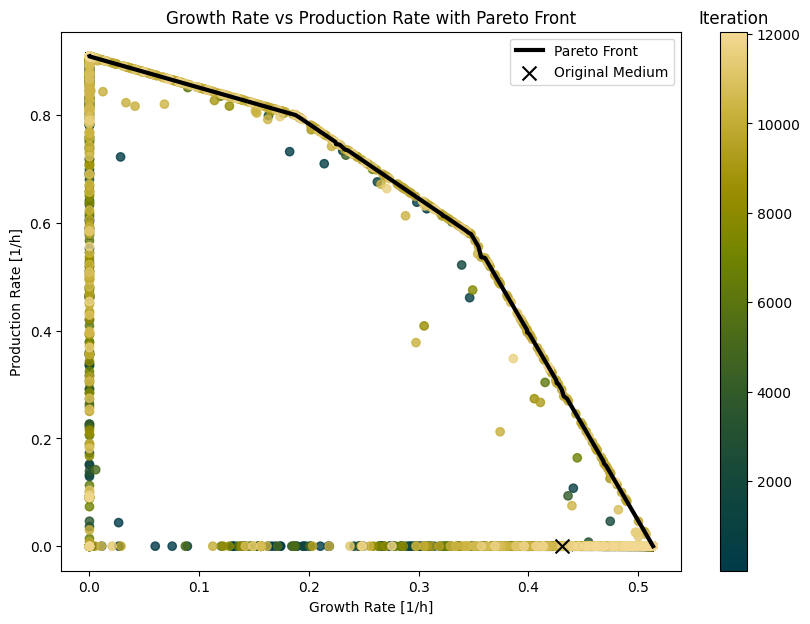

In [ ]:
figname = "2025-12-01_BayesOpt_iBsu1103_growth-production_combined_6runs_each200it_round_1_pareto.png"

plot_pareto(
    iBsu1103_results_combined, 
    xax = "growth rate tensors", 
    yax = "production tensors", 
    figname = figname,
    MetModel = model_iBsu1103,
    initial_medium = medium,
    initial_costs = costs,
    model_objective = model_iBsu1103.objective,
    )